In [1]:
import pandas 
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from numpy import arange
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm 
import itertools
from math import sqrt
from sklearn.tree import plot_tree
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LassoCV
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score,
    PredictionErrorDisplay
)
from sklearn.linear_model import RidgeCV

In [2]:
warnings.filterwarnings("ignore", message="X does not have valid feature names")

# -- Importing csv code -- 

In [3]:
ocean_dataset = pandas.read_csv('realistic_ocean_climate_dataset.csv', encoding='utf-8-sig')  
print(ocean_dataset.columns.tolist())                      
print([repr(col) for col in ocean_dataset.columns])        
ocean_dataset.columns = ocean_dataset.columns.str.strip()  
print([repr(col) for col in ocean_dataset.columns])        

print(ocean_dataset.index.name)
print(ocean_dataset.columns)
print(ocean_dataset.head())
print(ocean_dataset.info())
if 'Date' in ocean_dataset.columns:
    print("Column 'Date' does exist.")
else:
    print("Column 'Date' does not exist.")

['Date', 'Location', 'Latitude', 'Longitude', 'SST (°C)', 'pH Level', 'Bleaching Severity', 'Species Observed', 'Marine Heatwave']
["'Date'", "'Location'", "'Latitude'", "'Longitude'", "'SST (°C)'", "'pH Level'", "'Bleaching Severity'", "'Species Observed'", "'Marine Heatwave'"]
["'Date'", "'Location'", "'Latitude'", "'Longitude'", "'SST (°C)'", "'pH Level'", "'Bleaching Severity'", "'Species Observed'", "'Marine Heatwave'"]
None
Index(['Date', 'Location', 'Latitude', 'Longitude', 'SST (°C)', 'pH Level',
       'Bleaching Severity', 'Species Observed', 'Marine Heatwave'],
      dtype='object')
         Date            Location  Latitude  Longitude  SST (°C)  pH Level  \
0  2015-01-01             Red Sea   20.0248    38.4931     29.47     8.107   
1  2015-01-07  Great Barrier Reef  -18.2988   147.7782     29.65     8.004   
2  2015-01-14       Caribbean Sea   14.9768   -75.0233     28.86     7.947   
3  2015-01-20  Great Barrier Reef  -18.3152   147.6486     28.97     7.995   
4  2015-0

# -- Encoding --

## Ordinal Encoding

In [4]:
ocean_dataset['Bleaching Severity'] = ocean_dataset['Bleaching Severity'].fillna('None')


severity_map = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3}
heatwave_map = {False: 0, True: 1, 'FALSE': 0, 'TRUE': 1} 

ocean_dataset['Bleaching Severity Encoded'] = ocean_dataset['Bleaching Severity'].map(severity_map)
ocean_dataset['Marine Heatwave Encoded'] = ocean_dataset['Marine Heatwave'].map(heatwave_map)

ocean_dataset[['Bleaching Severity', 'Bleaching Severity Encoded', 'Marine Heatwave', 'Marine Heatwave Encoded']].head()


,Bleaching Severity,Bleaching Severity Encoded,Marine Heatwave,Marine Heatwave Encoded
0,None,0,False,0
1,High,3,False,0
2,High,3,False,0
3,Medium,2,False,0
4,None,0,False,0


# To Datetime

In [5]:
working_copy = ocean_dataset.copy()                                    
print("Index is", ocean_dataset.index.name)                            

if 'Date' in working_copy.columns:                                     
    working_copy['Date'] = pandas.to_datetime(working_copy['Date'])   
    working_copy = working_copy.sort_values('Date').set_index('Date')  
else:                                                                  
    print("Column 'Date' does not exist; cannot set as index.")        
    exit()                                                             
                                                                 

working_copy = working_copy.asfreq('7D').ffill().infer_objects()     

print("Index name:", working_copy.index.name)
print("NaNs in pH Level:", working_copy['pH Level'].isna().sum())


Index is None
Index name: Date
NaNs in pH Level: 0


C:\Users\kestr\AppData\Local\Temp\ipykernel_12368\3019747266.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  working_copy = working_copy.asfreq('7D').ffill().infer_objects()


# -- Exploratory Data Analysis -- 

## Correlation Heatmap

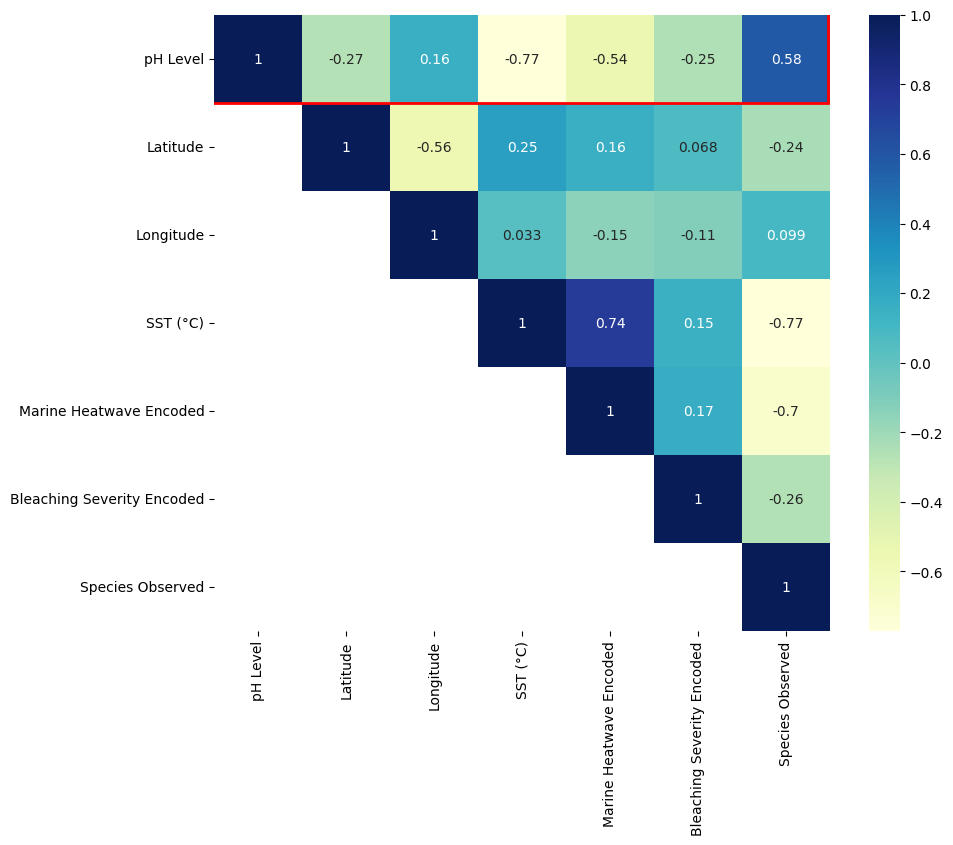

In [ ]:
cols_to_use = [
    'pH Level',
    'Latitude',
    'Longitude',
    'SST (°C)',
    'Marine Heatwave Encoded',
    'Bleaching Severity Encoded',
    'Species Observed'
]

filtered_df = working_copy[cols_to_use]
co_mtx = filtered_df.corr(numeric_only=True)

cols = co_mtx.columns.tolist()
cols.remove('pH Level') 
cols = ['pH Level'] + cols 
co_mtx_reordered = co_mtx.loc[cols, cols]

mask = numpy.tril(numpy.ones_like(co_mtx_reordered, dtype=bool), k=-1)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    co_mtx_reordered,
    mask=mask,
    cmap="YlGnBu",
    annot=True,
    square=True,
    cbar=True
)

n = co_mtx_reordered.shape[0]

rect = patches.Rectangle(
    xy=(-0.5, -0.5),  
    width=n+0.48,         
    height=1.5,        
    linewidth=2.0,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect)


# Autocorrelation heatmap

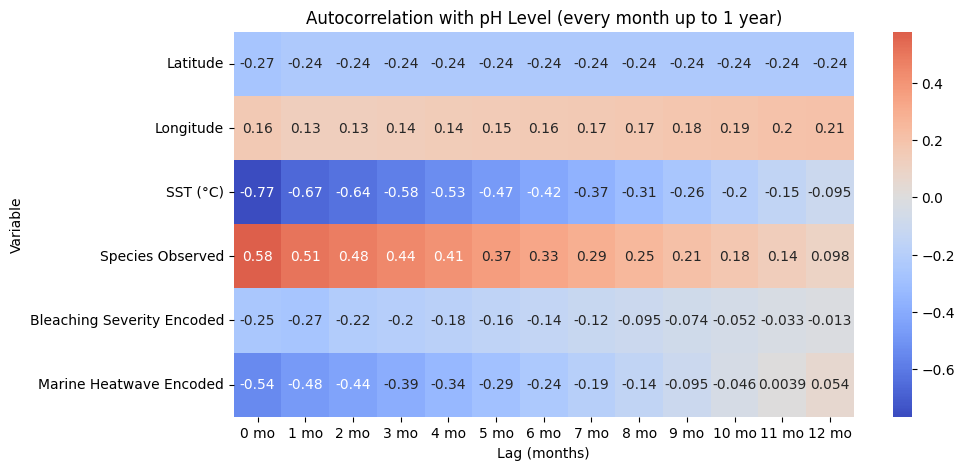

In [ ]:
numeric_df = working_copy.select_dtypes(include=[numpy.number])
target     = 'pH Level'
max_lag    = 12
corrs      = pandas.DataFrame(index=numeric_df.columns, columns=[f"{i} mo" for i in range(max_lag+1)], dtype=float)

for var in numeric_df.columns:
    for lag in range(max_lag + 1):
        shifted = numeric_df[var].shift(lag)
        corrs.loc[var, f"{lag} mo"] = numeric_df[target].corr(shifted)


corrs = corrs.drop(index=target)

plt.figure(figsize=(10,5))
sns.heatmap(corrs, annot=True, cmap='coolwarm', center=0)
plt.title(f"Autocorrelation with {target} (every month up to 1 year)")
plt.xlabel("Lag (months)")
plt.ylabel("Variable")
plt.show()

# Pairplot

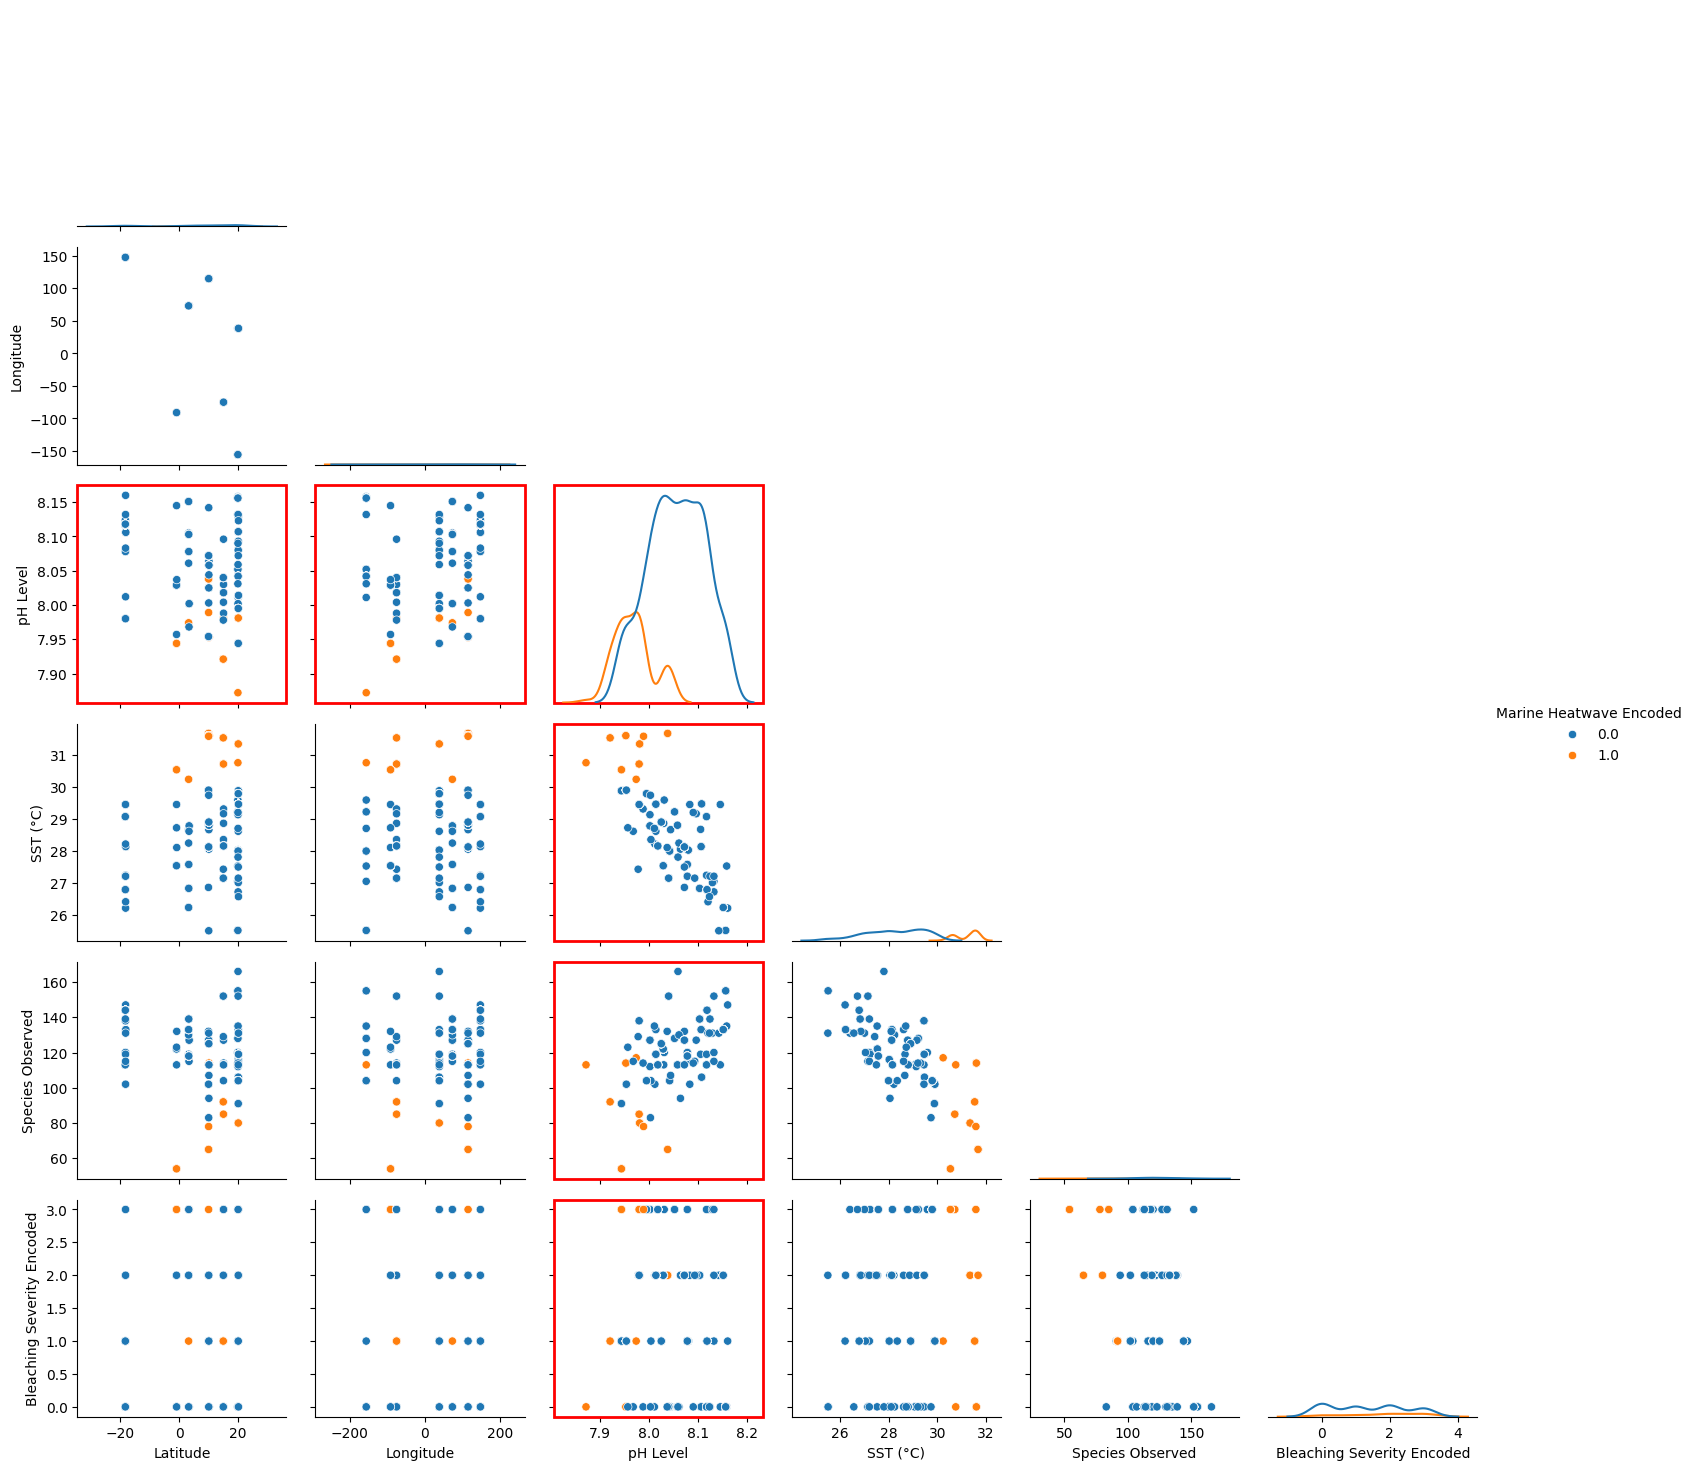

In [8]:
vars_to_plot = ['Latitude', 'Longitude', 'pH Level', 'SST (°C)', 'Species Observed', 'Bleaching Severity Encoded']

g = sns.PairGrid(working_copy, 
                 vars=vars_to_plot,
                 hue='Marine Heatwave Encoded',
                 corner=True) 

g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

for i, y_var in enumerate(g.y_vars):
    for j, x_var in enumerate(g.x_vars):
        if i < j:  
            continue
        ax = g.axes[i, j]
        if (x_var == 'pH Level') or (y_var == 'pH Level'):
            rect = mpatches.Rectangle(
                (0,0), 1, 1,
                transform=ax.transAxes,
                linewidth=2,
                edgecolor='red',
                facecolor='none',
                zorder=1000,
                clip_on=False
            )
            ax.add_patch(rect)

g.add_legend()
plt.show()

## Linear Regression

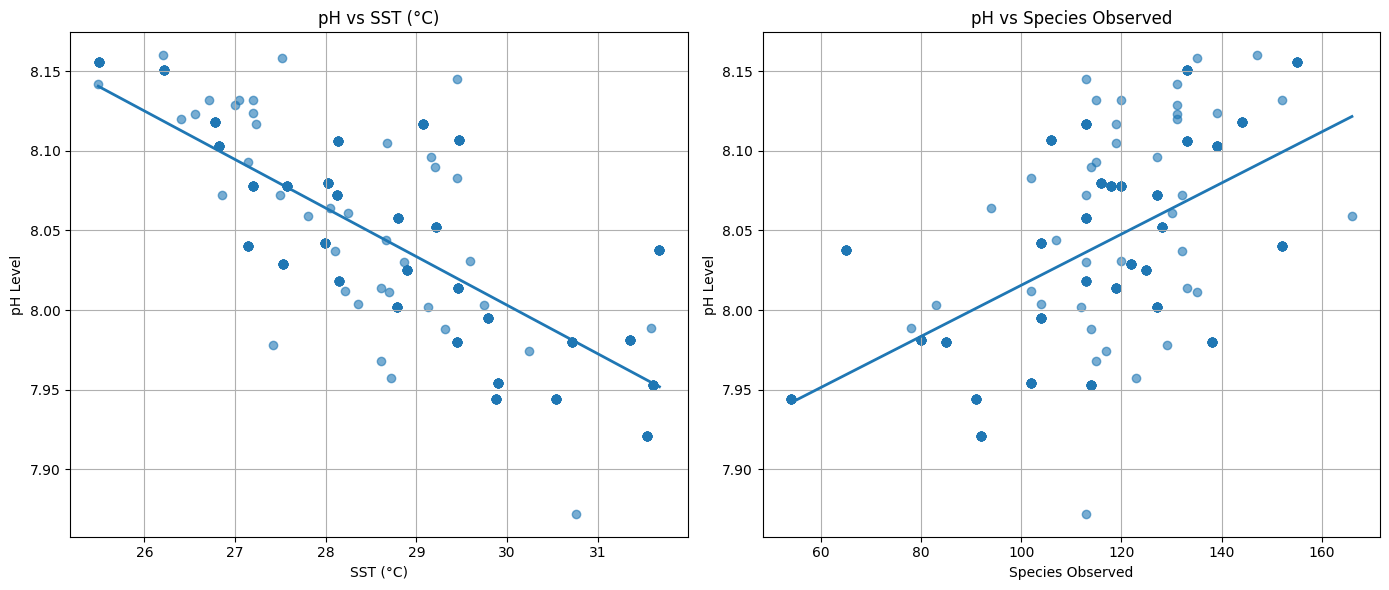

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

df = working_copy.copy()
x = df[['SST (°C)', 'Species Observed']]
y = df['pH Level']

features_to_plot = ['SST (°C)', 'Species Observed']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor("white")

for ax, feature in zip(axes, features_to_plot):

    x_var = x[[feature]]
    model = LinearRegression().fit(x_var, y)

    ax.scatter(x_var, y, alpha=0.6)

    x_range = np.linspace(x_var.min(), x_var.max(), 100).reshape(-1, 1)
    y_line  = model.predict(x_range)
    ax.plot(x_range, y_line, linewidth=2)

    ax.set_xlabel(feature)
    ax.set_ylabel("pH Level")
    ax.set_title(f"pH vs {feature}")
    ax.grid(True)

plt.tight_layout()
plt.show()


# -- Baseline ARIMA --

C:\Users\kestr\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kestr\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kestr\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kestr\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters


ARIMA Fold-wise Metrics:
Fold 1: RMSE=0.0414, MAE=0.0291, R2=-0.2573
Fold 2: RMSE=0.0589, MAE=0.0525, R2=0.0192
Fold 3: RMSE=0.0882, MAE=0.0731, R2=-0.1986
Fold 4: RMSE=0.0340, MAE=0.0276, R2=0.0043
Fold 5: RMSE=0.0567, MAE=0.0458, R2=0.0258
                               SARIMAX Results                                
Dep. Variable:               pH Level   No. Observations:                  399
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 811.719
Date:                Mon, 01 Dec 2025   AIC                          -1615.439
Time:                        19:43:40   BIC                          -1599.483
Sample:                    01-01-2015   HQIC                         -1609.119
                         - 08-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

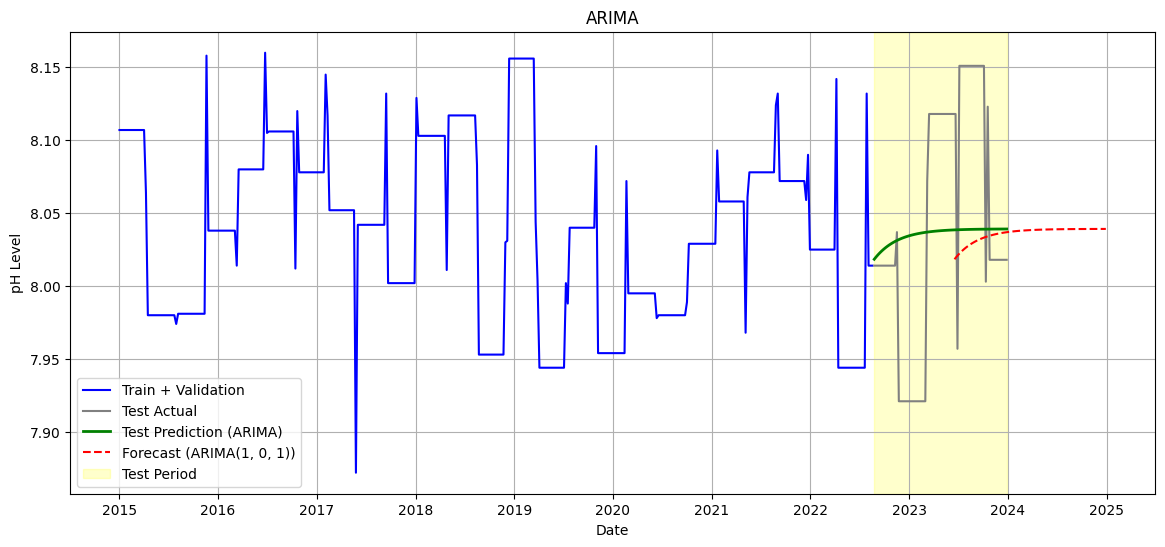

In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

df = working_copy.copy()
y = df["pH Level"]

train_size = int(len(y) * 0.7)
val_size   = int(len(y) * 0.15)

y_train      = y.iloc[:train_size]
y_val        = y.iloc[train_size:train_size + val_size]
y_test       = y.iloc[train_size + val_size:]

# Train + validation used for ARIMA
y_train_full = y.iloc[:train_size + val_size]

# Time Series CV
def time_series_cv_aic(y, order, n_splits=5):

    fold_size = len(y) // (n_splits + 1)
    aic_scores = []

    for i in range(n_splits):
        end_train = fold_size * (i + 1)
        y_train_fold = y.iloc[:end_train]

        try:
            model = ARIMA(y_train_fold, order=order)
            results = model.fit()
            aic_scores.append(results.aic)
        except:
            return np.inf, np.inf

    return aic_scores, np.mean(aic_scores)

# ARIMA hyperparameter grid
p_values = [0,1,2]
d_values = [0,1]
q_values = [0,1,2]

best_mean_aic = np.inf
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            fold_aic, mean_aic = time_series_cv_aic(y_train_full, order)
            if mean_aic < best_mean_aic:
                best_mean_aic = mean_aic
                best_order = order

# Fold wise metrics for ARIMA

def arima_fold_metrics(y, order, n_splits=5):
    fold_size = len(y) // (n_splits + 1)
    fold_rmse, fold_mae, fold_r2 = [], [], []

    for i in range(n_splits):
        end_train = fold_size * (i + 1)
        y_train_fold = y.iloc[:end_train]
        y_val_fold   = y.iloc[end_train:end_train + fold_size]

        if len(y_val_fold) == 0:
            break

        model = ARIMA(y_train_fold, order=order).fit()
        y_val_pred = model.predict(start=y_val_fold.index[0], end=y_val_fold.index[-1])

        fold_rmse.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))
        fold_mae.append(mean_absolute_error(y_val_fold, y_val_pred))
        fold_r2.append(r2_score(y_val_fold, y_val_pred))

    return fold_rmse, fold_mae, fold_r2

fold_rmse_arima, fold_mae_arima, fold_r2_arima = arima_fold_metrics(
    y_train_full, order=best_order, n_splits=5
)

print("\nARIMA Fold-wise Metrics:")
for i, (rmse, mae, r2) in enumerate(zip(fold_rmse_arima, fold_mae_arima, fold_r2_arima), 1):
    print(f"Fold {i}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

# Train final model
best_model = ARIMA(y_train_full, order=best_order).fit()
print(best_model.summary())

# Test set prediction
y_test_pred = best_model.predict(start=y_test.index[0], end=y_test.index[-1])

# Metrics on test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test  = mean_absolute_error(y_test, y_test_pred)
r2_test   = r2_score(y_test, y_test_pred)
naive_forecast = y_test.shift(1)
naive_mae = np.mean(np.abs(y_test[1:] - naive_forecast[1:]))
mase_test = mae_test / naive_mae

# Forecast
forecast_start_date = pd.Timestamp("2023-06-18")
forecast_end_date   = pd.Timestamp("2024-12-31")

freq = y.index.freq if y.index.freq is not None else pd.infer_freq(y.index)
if freq is None:
    freq = 'W'

n_steps = (forecast_end_date - forecast_start_date) // pd.Timedelta(weeks=1) + 1
forecast_obj = best_model.get_forecast(steps=n_steps)
y_pred_forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

future_index = pd.date_range(start=forecast_start_date, periods=len(y_pred_forecast), freq=freq)
y_pred_forecast.index = future_index
conf_int.index = future_index

# Train validation and test metrics

def get_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

y_train_pred = best_model.predict(start=y_train_full.index[0], end=y_train_full.index[-1])
rmse_train, mae_train, r2_train = get_metrics(y_train_full, y_train_pred)

y_val_pred = best_model.predict(start=y_val.index[0], end=y_val.index[-1])
rmse_val, mae_val, r2_val = get_metrics(y_val, y_val_pred)

y_test_pred = best_model.predict(start=y_test.index[0], end=y_test.index[-1])
rmse_test, mae_test, r2_test = get_metrics(y_test, y_test_pred)
naive_forecast_test = y_test.shift(1)
naive_mae_test = np.mean(np.abs(y_test[1:] - naive_forecast_test[1:]))
mase_test = mae_test / naive_mae_test

#Forecast metrics

last_train_val = y_train_full.iloc[-1]
naive_forecast_forecast = np.repeat(last_train_val, len(y_pred_forecast))
rmse_forecast = np.sqrt(mean_squared_error(naive_forecast_forecast, y_pred_forecast))
mae_forecast = mean_absolute_error(naive_forecast_forecast, y_pred_forecast)
mase_forecast = mae_forecast / mae_train

print("\n--- TRAIN METRICS ---")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE:  {mae_train:.4f}")
print(f"R²:   {r2_train:.4f}")

print("\n--- VALIDATION METRICS ---")
print(f"RMSE: {rmse_val:.4f}")
print(f"MAE:  {mae_val:.4f}")
print(f"R²:   {r2_val:.4f}")

print("\n--- TEST METRICS ---")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE:  {mae_test:.4f}")
print(f"R²:   {r2_test:.4f}")

print("\n--- FORECAST METRICS ---")
print(f"RMSE: {rmse_forecast:.4f}")
print(f"MAE:  {mae_forecast:.4f}")
print(f"MASE: {mase_forecast:.4f}")

# Plotting
plt.figure(figsize=(14,6))
plt.plot(y_train_full.index, y_train_full, label="Train + Validation", color="blue")
plt.plot(y_test.index, y_test, label="Test Actual", color="gray")
plt.plot(y_test_pred.index, y_test_pred, label="Test Prediction (ARIMA)", color="green", linewidth=2)
plt.plot(y_pred_forecast.index, y_pred_forecast, color="red", label=f"Forecast (ARIMA{best_order})", linestyle="--")
plt.axvspan(y_test.index[0], y_test.index[-1], color="yellow", alpha=0.2, label="Test Period")

plt.title("ARIMA")
plt.xlabel("Date")
plt.ylabel("pH Level")
plt.grid(True)
plt.legend()
plt.show()


# -- Model Testing -- 

## LassoCV

Fold 1: Optimal alpha=0.0010, RMSE=0.0531, MAE=0.0441, R2=-1.0552
Fold 2: Optimal alpha=0.0010, RMSE=0.0448, MAE=0.0363, R2=0.1106
Fold 3: Optimal alpha=0.0100, RMSE=0.0867, MAE=0.0797, R2=-0.1359
Fold 4: Optimal alpha=0.0100, RMSE=0.0588, MAE=0.0555, R2=-2.6283
Fold 5: Optimal alpha=0.0100, RMSE=0.0233, MAE=0.0201, R2=0.1945

Average CV metrics on training folds:
Mean RMSE: 0.0533
Mean MAE : 0.0471
Mean R2  : -0.7029

Optimal alpha on full training set: 0.0100

--- TRAIN METRICS ---
RMSE: 0.0435, MAE: 0.0368, R²: 0.4360

--- TEST METRICS ---
RMSE: 0.0499, MAE: 0.0454, R²: 0.6429

--- FORECAST METRICS (overlapping portion) ---
RMSE: 0.0519, MAE: 0.0468, MASE: 1.8104

Lasso Coefficients:
SST (°C): -0.0292
Marine Heatwave Encoded: -0.0000
Bleaching Severity Encoded: -0.0008
Species Observed: 0.0000
Latitude: -0.0000
Longitude: 0.0000


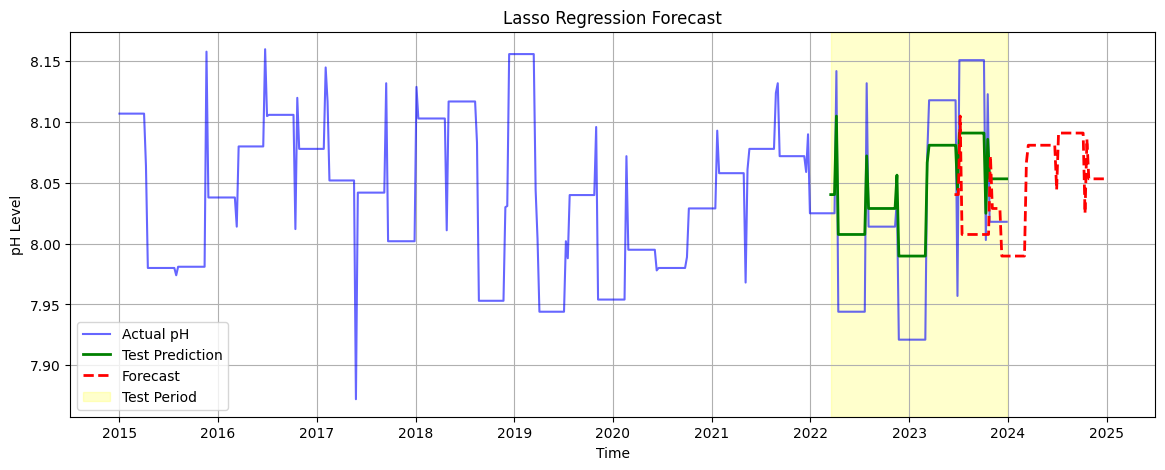

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

forecast_start_date = pd.to_datetime("2023-06-15")
forecast_end_date = pd.to_datetime("2024-12-31")
overlap = 25
n_splits = 5
alphas_grid = [0.0001, 0.001, 0.01, 0.1, 1]

y = working_copy['pH Level']
X = working_copy[['SST (°C)', 'Marine Heatwave Encoded', 'Bleaching Severity Encoded',
'Species Observed', 'Latitude', 'Longitude']]

# Train/test split

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Time Series CV

tscv = TimeSeriesSplit(n_splits=n_splits)
fold_mae_lasso, fold_rmse_lasso, fold_r2_lasso = [], [], []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]


    lasso_fold = LassoCV(alphas=alphas_grid, cv=3, max_iter=5000, random_state=42)
    lasso_fold.fit(X_tr, y_tr)

    y_val_pred = lasso_fold.predict(X_val)
    fold_mae_lasso.append(mean_absolute_error(y_val, y_val_pred))
    fold_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    fold_r2_lasso.append(r2_score(y_val, y_val_pred))

    print(f"Fold {fold+1}: Optimal alpha={lasso_fold.alpha_:.4f}, RMSE={fold_rmse_lasso[-1]:.4f}, MAE={fold_mae_lasso[-1]:.4f}, R2={fold_r2_lasso[-1]:.4f}")


print("\nAverage CV metrics on training folds:")
print(f"Mean RMSE: {np.mean(fold_rmse_lasso):.4f}")
print(f"Mean MAE : {np.mean(fold_mae_lasso):.4f}")
print(f"Mean R2  : {np.mean(fold_r2_lasso):.4f}")

# Fitting

final_lasso = LassoCV(alphas=alphas_grid, cv=tscv, max_iter=5000, random_state=42)
final_lasso.fit(X_train_scaled, y_train)
print(f"\nOptimal alpha on full training set: {final_lasso.alpha_:.4f}")

# Predictions for train and test sets

y_train_pred = final_lasso.predict(X_train_scaled)
y_test_pred = final_lasso.predict(X_test_scaled)

# Metrics

def get_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

rmse_train, mae_train, r2_train = get_metrics(y_train, y_train_pred)
rmse_test, mae_test, r2_test = get_metrics(y_test, y_test_pred)

# Prepare forecast input

n_forecast = len(pd.date_range(forecast_start_date, forecast_end_date, freq='W'))

if overlap > 0:
    X_forecast_input = pd.concat([X_test.iloc[:overlap], X_test.iloc[-(n_forecast-overlap):]]).copy()
else:
    X_forecast_input = X_test.iloc[-n_forecast:].copy()

# Scale and predict
X_forecast_scaled = scaler.transform(X_forecast_input)
y_forecast_pred = final_lasso.predict(X_forecast_scaled)
future_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='W')
y_forecast_series = pd.Series(y_forecast_pred[:len(future_index)], index=future_index)

# Forecast metrics on overlapping portion

if overlap > 0:
    y_overlap = y_test.iloc[:overlap]
    y_forecast_overlap = y_forecast_series.iloc[:overlap]
    rmse_forecast = np.sqrt(mean_squared_error(y_overlap, y_forecast_overlap))
    mae_forecast = mean_absolute_error(y_overlap, y_forecast_overlap)
    naive_mae = np.mean(np.abs(y_overlap[1:].values - y_overlap[:-1].values))
    mase_forecast = mae_forecast / naive_mae
else:
    rmse_forecast = mae_forecast = mase_forecast = np.nan

# Metrics summary

print("\n--- TRAIN METRICS ---")
print(f"RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, R²: {r2_train:.4f}")

print("\n--- TEST METRICS ---")
print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, R²: {r2_test:.4f}")

if overlap > 0:
    print("\n--- FORECAST METRICS (overlapping portion) ---")
    print(f"RMSE: {rmse_forecast:.4f}, MAE: {mae_forecast:.4f}, MASE: {mase_forecast:.4f}")

# Lasso coefficients

print("\nLasso Coefficients:")
for name, coef in zip(X.columns, final_lasso.coef_):
    print(f"{name}: {coef:.4f}")

# Plot

plt.figure(figsize=(14,5))
plt.plot(y, label="Actual pH", alpha=0.6, color='blue')
plt.plot(y_test.index, y_test_pred, label="Test Prediction", linewidth=2, color='green')
plt.plot(y_forecast_series.index, y_forecast_series.values,
linestyle='--', color='red', linewidth=2, label="Forecast")
plt.axvspan(y_test.index[0], y_test.index[-1], color="yellow", alpha=0.2, label="Test Period")
plt.title("Lasso Regression Forecast")
plt.xlabel("Time")
plt.ylabel("pH Level")
plt.grid(True)
plt.legend()
plt.show()


## RidgeCV

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Ridge alpha: 10
Fold 1 metrics list length: 1
Fold 2 metrics list length: 2
Fold 3 metrics list length: 3
Fold 4 metrics list length: 4
Fold 5 metrics list length: 5
Fold 5:
  Train RMSE=0.0425, MAE=0.0361, R2=0.5231
  Val   RMSE=0.0235, MAE=0.0178, R2=0.1799

Average Training metrics (fold-wise):
Mean RMSE: 0.0309
Mean MAE : 0.0243
Mean R2  : 0.6850

Average Validation (CV) metrics:
Mean RMSE: 0.0500
Mean MAE : 0.0436
Mean R2  : -0.4961

Test set metrics:
RMSE: 0.0402
MAE:  0.0327
R²:   0.7677

Forecast evaluation on overlapping test portion (25 points):
RMSE: 0.0529, MAE: 0.0447, MASE: 1.7286

Ridge Coefficients:
SST (°C): -0.0493
Marine Heatwave Encoded: 0.0076
Bleaching Severity Encoded: -0.0095
Species Observed: -0.0089
Latitude: -0.0034
Longitude: 0.0051


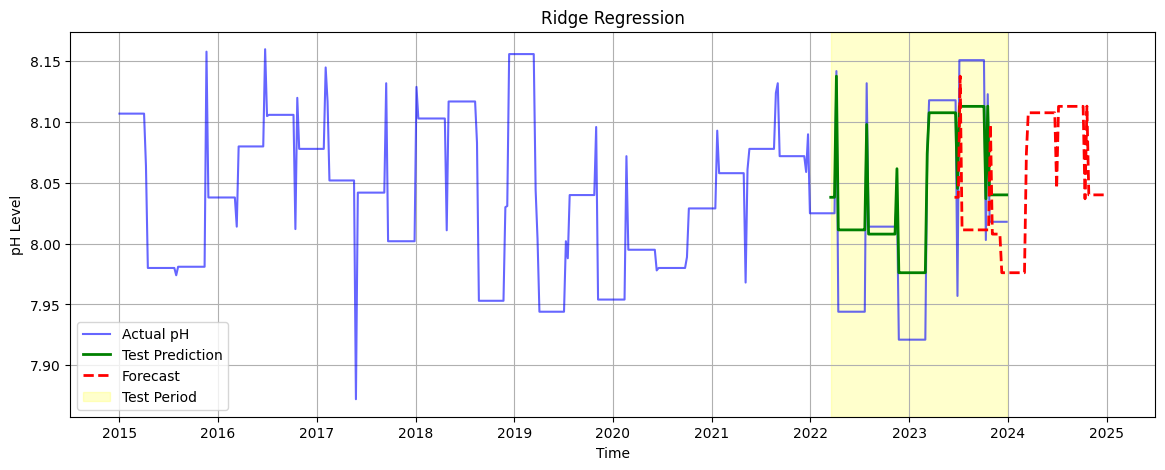

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt

forecast_start_date = pd.to_datetime("2023-06-15")  
forecast_end_date = pd.to_datetime("2024-12-31")    
overlap = 25                                        
n_splits = 5                                       
alpha_grid = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] 

y = working_copy['pH Level']
X = working_copy[['SST (°C)', 'Marine Heatwave Encoded', 'Bleaching Severity Encoded',
'Species Observed', 'Latitude', 'Longitude']]

# Train/Test Split 

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# GridSearchCV

tscv = TimeSeriesSplit(n_splits=n_splits)
ridge = Ridge()
param_grid = {'alpha': alpha_grid}

grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=tscv,
scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_alpha = grid_search.best_params_['alpha']
print("Best Ridge alpha:", best_alpha)

# Fold-wise metrics

fold_train_mae, fold_train_rmse, fold_train_r2 = [], [], []
fold_val_mae_ridge, fold_val_rmse_ridge, fold_val_r2_ridge = [], [], []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    fold_model = Ridge(alpha=best_alpha)
    fold_model.fit(X_tr, y_tr)

    # Training metrics
    y_tr_pred = fold_model.predict(X_tr)
    fold_train_mae.append(mean_absolute_error(y_tr, y_tr_pred))
    fold_train_rmse.append(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    fold_train_r2.append(r2_score(y_tr, y_tr_pred))

    # Validation metrics
    y_val_pred = fold_model.predict(X_val)
    fold_val_rmse_ridge.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    fold_val_mae_ridge.append(mean_absolute_error(y_val, y_val_pred))
    fold_val_r2_ridge.append(r2_score(y_val, y_val_pred))

    print(f"Fold {fold+1} metrics list length: {len(fold_val_mae_ridge)}")

print(f"Fold {fold+1}:")
print(f"  Train RMSE={fold_train_rmse[-1]:.4f}, MAE={fold_train_mae[-1]:.4f}, R2={fold_train_r2[-1]:.4f}")
print(f"  Val   RMSE={fold_val_rmse_ridge[-1]:.4f}, MAE={fold_val_mae_ridge[-1]:.4f}, R2={fold_val_r2_ridge[-1]:.4f}")


print("\nAverage Training metrics (fold-wise):")
print(f"Mean RMSE: {np.mean(fold_train_rmse):.4f}")
print(f"Mean MAE : {np.mean(fold_train_mae):.4f}")
print(f"Mean R2  : {np.mean(fold_train_r2):.4f}")

print("\nAverage Validation (CV) metrics:")
print(f"Mean RMSE: {np.mean(fold_val_rmse_ridge):.4f}")
print(f"Mean MAE : {np.mean(fold_val_mae_ridge):.4f}")
print(f"Mean R2  : {np.mean(fold_val_r2_ridge):.4f}")

# Fitting

final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train_scaled, y_train)
y_test_pred = final_model.predict(X_test_scaled)

# Test set

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nTest set metrics:")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE:  {mae_test:.4f}")
print(f"R²:   {r2_test:.4f}")

# Forecast input

if overlap > 0:
    X_forecast_input = pd.concat([
    X_test.iloc[:overlap],
    X_test.iloc[-(len(pd.date_range(forecast_start_date, forecast_end_date, freq='W'))-overlap):]
    ])
else:
    X_forecast_input = X_test.iloc[-len(pd.date_range(forecast_start_date, forecast_end_date, freq='W')):]

X_forecast_scaled = scaler.transform(X_forecast_input)
y_forecast_pred = final_model.predict(X_forecast_scaled)

freq = y.index.freq if isinstance(y.index, pd.DatetimeIndex) and y.index.freq else pd.infer_freq(y.index)
if freq is None:
    freq = 'W'
    future_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq=freq)

if len(y_forecast_pred) != len(future_index):
    y_forecast_pred = y_forecast_pred[:len(future_index)]

y_forecast_series = pd.Series(y_forecast_pred, index=future_index)

if overlap > 0:
    y_overlap = y_test.iloc[:overlap]
    y_forecast_overlap = y_forecast_series.iloc[:overlap]


rmse_forecast = np.sqrt(mean_squared_error(y_overlap, y_forecast_overlap))
mae_forecast = mean_absolute_error(y_overlap, y_forecast_overlap)
naive_mae = np.mean(np.abs(y_overlap[1:].values - y_overlap[:-1].values))
mase = mae_forecast / naive_mae

print(f"\nForecast evaluation on overlapping test portion ({overlap} points):")
print(f"RMSE: {rmse_forecast:.4f}, MAE: {mae_forecast:.4f}, MASE: {mase:.4f}")


# Ridge coefficients

print("\nRidge Coefficients:")
for name, coef in zip(X.columns, final_model.coef_):
    print(f"{name}: {coef:.4f}")

# Plot

plt.figure(figsize=(14,5))
plt.plot(y, label="Actual pH", alpha=0.6, color='blue')
plt.plot(y_test.index, y_test_pred, label="Test Prediction", linewidth=2, color='green')
plt.plot(y_forecast_series.index, y_forecast_series.values,
linestyle='--', color='red', linewidth=2, label="Forecast")
plt.axvspan(y_test.index[0], y_test.index[-1], color="yellow", alpha=0.2, label="Test Period")
plt.title("Ridge Regression")
plt.xlabel("Time")
plt.ylabel("pH Level")
plt.grid(True)
plt.legend()
plt.show()


## Random Forest


=== TimeSeriesSplit Fold Metrics ===
Fold 1:
  Train RMSE=0.0081, MAE=0.0028, R2=0.9103
  Val   RMSE=0.0491, MAE=0.0386, R2=0.0947
Fold 2:
  Train RMSE=0.0121, MAE=0.0041, R2=0.9238
  Val   RMSE=0.0783, MAE=0.0674, R2=0.2671
Fold 3:
  Train RMSE=0.0100, MAE=0.0036, R2=0.9760
  Val   RMSE=0.0355, MAE=0.0305, R2=0.1917
Fold 4:
  Train RMSE=0.0086, MAE=0.0031, R2=0.9828
  Val   RMSE=0.0411, MAE=0.0351, R2=-0.2845
Fold 5:
  Train RMSE=0.0084, MAE=0.0032, R2=0.9814
  Val   RMSE=0.0219, MAE=0.0171, R2=0.8338

Average Training metrics (fold-wise):
Mean RMSE: 0.0094
Mean MAE : 0.0034
Mean R2  : 0.9549

Average Validation metrics (fold-wise):
Mean RMSE: 0.0452
Mean MAE : 0.0378
Mean R2  : 0.2205
Best params: {'model__max_depth': 10, 'model__min_samples_split': 20, 'model__n_estimators': 500}

=== Test set metrics ===
R2: 0.8875, MAE: 0.0198, RMSE: 0.0281

Forecast evaluation on overlapping test portion (25 points):
RMSE: 0.0727, MAE: 0.0665, MASE: 3.5841


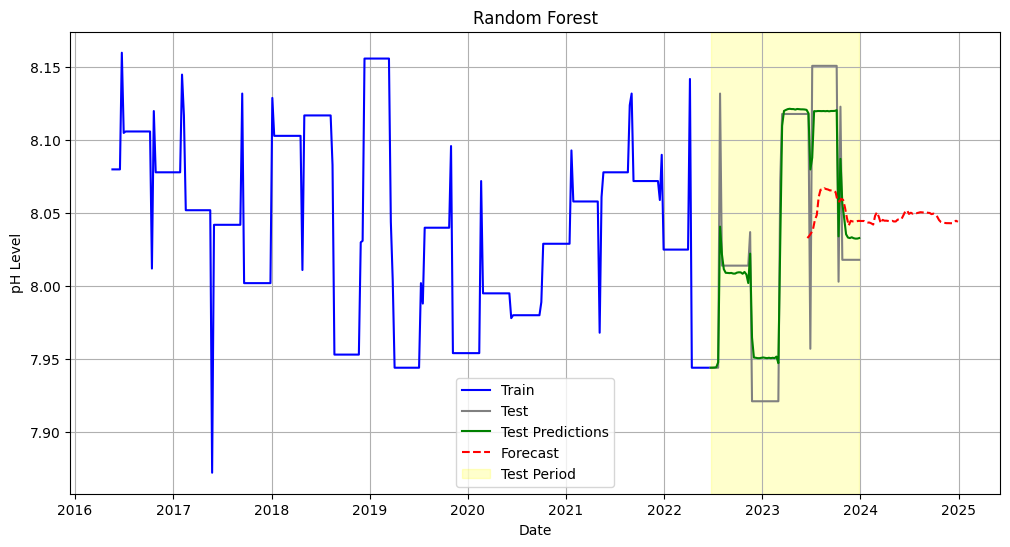

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

RANDOM_STATE = 42
LAGS = 72
overlap = 25  
forecast_start_date = pd.to_datetime("2023-06-15")  

df = working_copy.copy()
TARGET = "pH Level"

if isinstance(df.index, pd.DatetimeIndex):
    df = df.sort_index()
    dates = df.index
else:
    time_cols = ['date', 'Date', 'datetime', 'timestamp', 'time', 'Time']
    for col in time_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
            df = df.sort_values(by=col).reset_index(drop=True)
            dates = df[col]
            break
    else:
        raise ValueError("No datetime column or DatetimeIndex found.")

possible_features = [
    "Location", "Latitude", "Longitude",
    "SST (°C)", "Species Observed",
    "Bleaching Severity Encoded",
    "Marine Heatwave Encoded"
]
features = [f for f in possible_features if f in df.columns]


def create_lags(df, target_col, lags=3, dates=None):
    df_lag = df.copy()
    for lag in range(1, lags + 1):
        df_lag[f"{target_col}_lag{lag}"] = df_lag[target_col].shift(lag)
    df_lag = df_lag.dropna().reset_index(drop=True)
   
    if dates is not None:
        if isinstance(dates, pd.Series):
            df_lag['Date'] = dates.iloc[lags:].reset_index(drop=True)
        elif isinstance(dates, pd.DatetimeIndex):
            df_lag['Date'] = pd.Series(dates[lags:]).reset_index(drop=True)
        else:
            raise ValueError("dates must be a Series or DatetimeIndex")
    else:
        df_lag['Date'] = df.index[lags:]
    return df_lag

df_lagged = create_lags(df, TARGET, lags=LAGS, dates=dates)
lag_features = [f"{TARGET}_lag{lag}" for lag in range(1, LAGS + 1)]
all_features = features + lag_features
X = df_lagged[all_features].copy()
y = df_lagged[TARGET].copy()
dates = df_lagged['Date']


# Train/test split
TEST_SIZE = 0.2
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_train, dates_test = dates.iloc[:split_idx], dates.iloc[split_idx:]

# Preprocessing
cat_features = [c for c in X.columns if X[c].dtype == 'object' or X[c].dtype.name == 'category']
num_features = [c for c in X.columns if c not in cat_features]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')


# Random Forest
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', rf)
])

# TimeSeriesSplit CV

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
fold_train_rmse, fold_train_mae, fold_train_r2 = [], [], []
fold_val_rmse_rf, fold_val_mae_rf, fold_val_r2_rf = [], [], []

print("\n=== TimeSeriesSplit Fold Metrics ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    fold_model = clone(pipeline)
    fold_model.fit(X_tr, y_tr)

    # Training metrics 
    y_tr_pred = fold_model.predict(X_tr)
    fold_train_rmse.append(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    fold_train_mae.append(mean_absolute_error(y_tr, y_tr_pred))
    fold_train_r2.append(r2_score(y_tr, y_tr_pred))

    # Validation metrics 
    y_val_pred = fold_model.predict(X_val)
    fold_val_rmse_rf.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    fold_val_mae_rf.append(mean_absolute_error(y_val, y_val_pred))
    fold_val_r2_rf.append(r2_score(y_val, y_val_pred))

    print(f"Fold {fold+1}:")
    print(f"  Train RMSE={fold_train_rmse[-1]:.4f}, MAE={fold_train_mae[-1]:.4f}, R2={fold_train_r2[-1]:.4f}")
    print(f"  Val   RMSE={fold_val_rmse_rf[-1]:.4f}, MAE={fold_val_mae_rf[-1]:.4f}, R2={fold_val_r2_rf[-1]:.4f}")


print("\nAverage Training metrics (fold-wise):")
print(f"Mean RMSE: {np.mean(fold_train_rmse):.4f}")
print(f"Mean MAE : {np.mean(fold_train_mae):.4f}")
print(f"Mean R2  : {np.mean(fold_train_r2):.4f}")

print("\nAverage Validation metrics (fold-wise):")
print(f"Mean RMSE: {np.mean(fold_val_rmse_rf):.4f}")
print(f"Mean MAE : {np.mean(fold_val_mae_rf):.4f}")
print(f"Mean R2  : {np.mean(fold_val_r2_rf):.4f}")

# Grid search 

param_grid = {
    'model__n_estimators': [100, 300, 500, 1000, 1500],
    'model__max_depth': [None, 10, 20, 30, 50],
    'model__min_samples_split': [2, 5, 10, 20]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=tscv, scoring='r2')
grid_search.fit(X_train, y_train)

rf_best_model = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)

best_model = rf_best_model

best_model = rf_best_model

# Test set evaluation

y_test_pred = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
final_mae = mean_absolute_error(y_test, y_test_pred)
final_r2 = r2_score(y_test, y_test_pred)
print("\n=== Test set metrics ===")
print(f"R2: {final_r2:.4f}, MAE: {final_mae:.4f}, RMSE: {final_rmse:.4f}")

# Forecast 
freq = 'W'
future_index = pd.date_range(start=forecast_start_date, end=pd.to_datetime("2024-12-31"), freq=freq)
FORECAST_WEEKS = len(future_index)

if overlap > 0:
    X_forecast_input = pd.concat([X_test.iloc[:overlap], X_test.iloc[-(FORECAST_WEEKS - overlap):]])
else:
    X_forecast_input = X_test.iloc[-FORECAST_WEEKS:]

last_known = X_forecast_input.tail(LAGS).copy().reset_index(drop=True)
future_preds = []

for i in range(FORECAST_WEEKS):
    X_next = last_known.tail(LAGS).iloc[-1]
    X_next_df = pd.DataFrame([X_next], columns=all_features)
    y_next = best_model.predict(X_next_df)[0]
    future_preds.append(y_next)

    new_row = X_next.copy()
    for lag in range(LAGS, 1, -1):
        new_row[f"{TARGET}_lag{lag}"] = new_row[f"{TARGET}_lag{lag-1}"]
    new_row[f"{TARGET}_lag1"] = y_next
    last_known = pd.concat([last_known, new_row.to_frame().T], ignore_index=True)

y_forecast_series = pd.Series(future_preds, index=future_index)

# Evaluate forecast
if overlap > 0:
    y_overlap = y_test.iloc[:overlap]
    y_forecast_overlap = y_forecast_series.iloc[:overlap]
    rmse_forecast = np.sqrt(mean_squared_error(y_overlap, y_forecast_overlap))
    mae_forecast = mean_absolute_error(y_overlap, y_forecast_overlap)
    naive_mae = np.mean(np.abs(y_overlap[1:].values - y_overlap[:-1].values))
    mase = mae_forecast / naive_mae
    print(f"\nForecast evaluation on overlapping test portion ({overlap} points):")
    print(f"RMSE: {rmse_forecast:.4f}, MAE: {mae_forecast:.4f}, MASE: {mase:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_test, y_test, label='Test', color='gray')
plt.plot(dates_test, y_test_pred, label='Test Predictions', color='green')
plt.plot(future_index, y_forecast_series, label='Forecast', color='red', linestyle='--')
plt.axvspan(dates_test.iloc[0], dates_test.iloc[-1], color='yellow', alpha=0.2, label='Test Period')
plt.xlabel('Date')
plt.ylabel('pH Level')
plt.title('Random Forest')
plt.legend()
plt.grid(True)
plt.show()


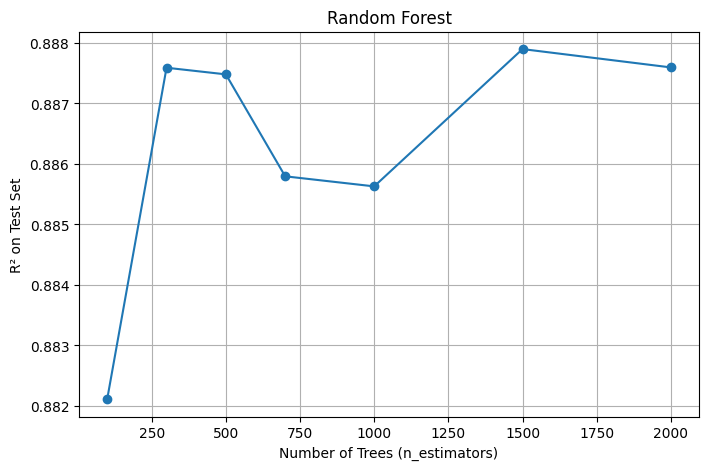

In [14]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.metrics import r2_score


n_tree_list = [100, 300, 500, 700, 1000, 1500, 2000]
r2_scores = []

for n_trees in n_tree_list:
    rf_temp = RandomForestRegressor(
    n_estimators=n_trees,
    max_depth=best_model.named_steps['model'].max_depth,
    min_samples_split=best_model.named_steps['model'].min_samples_split,
    random_state=RANDOM_STATE,
    n_jobs=-1
    )

    pipeline_temp = Pipeline([
    ('pre', preprocessor),
    ('model', rf_temp)
    ])
    pipeline_temp.fit(X_train, y_train)
    y_val_pred = pipeline_temp.predict(X_test)
    r2_scores.append(r2_score(y_test, y_val_pred))


plt.figure(figsize=(8,5))
plt.plot(n_tree_list, r2_scores, marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("R² on Test Set")
plt.title("Random Forest")
plt.grid(True)
plt.savefig("Hyperparameter_Tuning_RF.png")
plt.show()


## XGBoost


=== TimeSeriesSplit Fold Metrics ===
Fold 1:
  Train -> RMSE=0.0003, MAE=0.0002, R2=1.0000
  Val   -> RMSE=0.0378, MAE=0.0272, R2=-0.0440
Fold 2:
  Train -> RMSE=0.0005, MAE=0.0002, R2=0.9999
  Val   -> RMSE=0.0355, MAE=0.0278, R2=0.4412
Fold 3:
  Train -> RMSE=0.0005, MAE=0.0002, R2=0.9999
  Val   -> RMSE=0.0641, MAE=0.0583, R2=0.3783
Fold 4:
  Train -> RMSE=0.0005, MAE=0.0002, R2=0.9999
  Val   -> RMSE=0.0381, MAE=0.0306, R2=-0.5201
Fold 5:
  Train -> RMSE=0.0006, MAE=0.0002, R2=0.9999
  Val   -> RMSE=0.0335, MAE=0.0253, R2=-0.6712

Average Training metrics (fold-wise):
Mean RMSE: 0.0005
Mean MAE : 0.0002
Mean R2  : 0.9999

Average Validation metrics (fold-wise):
Mean RMSE: 0.0418
Mean MAE : 0.0338
Mean R2  : -0.0832
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

Test Set Metrics with Best Model:
MAE: 0.03397673379613988
RMSE: 0.039774951

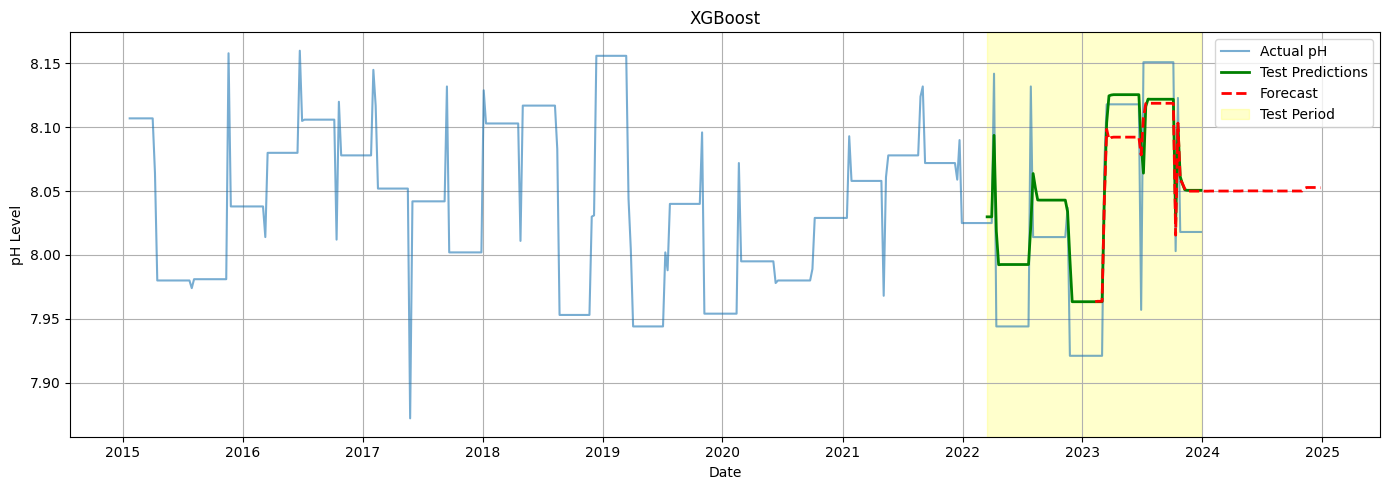

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.base import clone

lags = [1, 2, 3]
forecast_start_pct = 0.5     
forecast_end_year = 2024       
trend_features = {
    'SST (°C)': 0.01,
    'Marine Heatwave Encoded': 0.01,
    'Bleaching Severity Encoded': 0.01,
    'Species Observed': 0.01
}
manual_overlap = 25           
n_splits = 5                  

y = working_copy['pH Level']
X = working_copy[['SST (°C)', 'Marine Heatwave Encoded', 'Bleaching Severity Encoded',
                  'Species Observed', 'Latitude', 'Longitude']]

def create_lags(df, target_col, lags=[1,2,3]):
    df_lag = df.copy()
    for lag in lags:
        df_lag[f'{target_col}_lag{lag}'] = df_lag[target_col].shift(lag)
    return df_lag

data = X.copy()
data['pH'] = y
data = create_lags(data, 'pH', lags=lags)
data = data.dropna()

# Split features
y = data['pH']
X = data.drop('pH', axis=1)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TimeSeriesSplit 
tscv = TimeSeriesSplit(n_splits=n_splits)
fold_train_rmse, fold_train_mae, fold_train_r2 = [], [], []
fold_val_rmse_xg, fold_val_mae_xg, fold_val_r2_xg = [], [], []

print("\n=== TimeSeriesSplit Fold Metrics ===")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    fold_model = xgb.XGBRegressor(random_state=42)
    fold_model.fit(X_tr, y_tr)
    
    # Training metrics 
    y_tr_pred = fold_model.predict(X_tr)
    fold_train_rmse.append(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    fold_train_mae.append(mean_absolute_error(y_tr, y_tr_pred))
    fold_train_r2.append(r2_score(y_tr, y_tr_pred))
    
    # Validation metrics 
    y_val_pred = fold_model.predict(X_val)
    fold_val_rmse_xg.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    fold_val_mae_xg.append(mean_absolute_error(y_val, y_val_pred))
    fold_val_r2_xg.append(r2_score(y_val, y_val_pred))
    
    print(f"Fold {fold+1}:")
    print(f"  Train -> RMSE={fold_train_rmse[-1]:.4f}, MAE={fold_train_mae[-1]:.4f}, R2={fold_train_r2[-1]:.4f}")
    print(f"  Val   -> RMSE={fold_val_rmse_xg[-1]:.4f}, MAE={fold_val_mae_xg[-1]:.4f}, R2={fold_val_r2_xg[-1]:.4f}")

# Average fold metrics 
print("\nAverage Training metrics (fold-wise):")
print(f"Mean RMSE: {np.mean(fold_train_rmse):.4f}")
print(f"Mean MAE : {np.mean(fold_train_mae):.4f}")
print(f"Mean R2  : {np.mean(fold_train_r2):.4f}")

print("\nAverage Validation metrics (fold-wise):")
print(f"Mean RMSE: {np.mean(fold_val_rmse_xg):.4f}")
print(f"Mean MAE : {np.mean(fold_val_mae_xg):.4f}")
print(f"Mean R2  : {np.mean(fold_val_r2_xg):.4f}")

# Grid Search 
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=tscv, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best model 
best_model = grid_search.best_estimator_
print("\nBest XGBoost parameters:", grid_search.best_params_)

# Test predictions
y_pred_test = best_model.predict(X_test_scaled)

# Test metrics 
print("\nTest Set Metrics with Best Model:")
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R²: ", r2_score(y_test, y_pred_test))

# Forecasting 
if not isinstance(y.index, pd.DatetimeIndex):
    raise ValueError("y.index must be a DatetimeIndex for date-based forecasting.")

start_idx = int(len(X_test) * forecast_start_pct)
forecast_start_date = y_test.index[start_idx]

last_known = pd.concat([X_test.iloc[:start_idx], y_test.iloc[:start_idx]], axis=1).tail(max(lags)).copy()
future_preds = []
future_dates = []

last_week_2024 = pd.Timestamp(year=forecast_end_year, month=12, day=31)
freq = y.index.freq if y.index.freq is not None else pd.infer_freq(y.index)
if freq is None:
    freq = 'W'
n_steps = ((last_week_2024 - forecast_start_date) // pd.Timedelta(weeks=1)) + 1

for i in range(n_steps):
    if start_idx + i < len(X_test):
        next_row = X_test.iloc[start_idx + i:start_idx + i + 1].copy()
    else:
        next_row = X_test.iloc[[-1]].copy()
    
    for j, lag in enumerate(lags):
        next_row[f'pH_lag{lag}'] = last_known['pH'].iloc[-lag]
    
    for f, t in trend_features.items():
        next_row[f] = next_row[f].iloc[0] + t*(i+1)
    
    next_row_scaled = scaler.transform(next_row[X_train.columns])
    y_next = best_model.predict(next_row_scaled)[0]
    future_preds.append(y_next)
    
    new_row = next_row.copy()
    new_row['pH'] = y_next
    last_known = pd.concat([last_known, new_row], ignore_index=True).iloc[-max(lags):]
    
    future_date = forecast_start_date + pd.to_timedelta(i*7, unit='d')
    future_dates.append(future_date)

y_future_series = pd.Series(future_preds, index=future_dates)

# overlap evaluation
manual_overlap = min(manual_overlap, len(y_test) - start_idx, len(future_preds))
if manual_overlap > 0:
    y_overlap = y_test.iloc[start_idx:start_idx+manual_overlap]
    y_forecast_overlap = y_future_series.iloc[:manual_overlap]
    
    rmse_forecast = np.sqrt(mean_squared_error(y_overlap, y_forecast_overlap))
    mae_forecast = mean_absolute_error(y_overlap, y_forecast_overlap)
    naive_mae = np.mean(np.abs(y_overlap[1:].values - y_overlap[:-1].values))
    mase = mae_forecast / naive_mae if naive_mae != 0 else np.nan
    
    print(f"\nManual overlap evaluation ({manual_overlap} points):")
    print(f"RMSE: {rmse_forecast:.4f}")
    print(f"MAE:  {mae_forecast:.4f}")
    print(f"MASE: {mase:.4f}")

# Plot
plt.figure(figsize=(14,5))
plt.plot(y, label="Actual pH", alpha=0.6)
plt.plot(y_test.index, y_pred_test, label="Test Predictions", color="green", linewidth=2)
plt.plot(y_future_series.index, y_future_series.values, linestyle='--', color="red", linewidth=2, label="Forecast")
plt.axvspan(y_test.index[0], y_test.index[-1], color="yellow", alpha=0.2, label="Test Period")

plt.title(f"XGBoost")
plt.xlabel("Date")
plt.ylabel("pH Level")
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


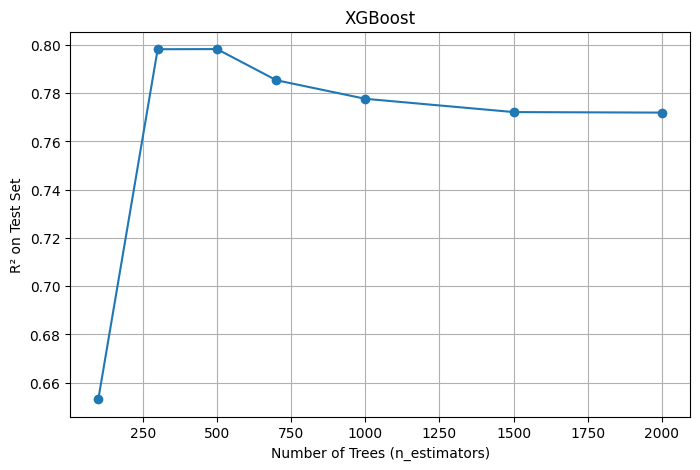

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

y = data['pH']
X = data.drop('pH', axis=1)

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_1d = np.ravel(y_train)
y_test_1d = np.ravel(y_test)

assert X_train_scaled.shape[0] == y_train_1d.shape[0], f"X_train: {X_train_scaled.shape[0]}, y_train: {y_train_1d.shape[0]}"
assert X_test_scaled.shape[0] == y_test_1d.shape[0], f"X_test: {X_test_scaled.shape[0]}, y_test: {y_test_1d.shape[0]}"

# XGBoost

n_estimators_list = [100, 300, 500, 700, 1000, 1500, 2000]
r2_scores = []

# GridSearchCV

best_params = grid_search.best_params_
fixed_params = {
'max_depth': best_params.get('max_depth', 3),
'learning_rate': best_params.get('learning_rate', 0.1),
'subsample': best_params.get('subsample', 1.0),
'colsample_bytree': best_params.get('colsample_bytree', 1.0),
'random_state': 42
}

for n in n_estimators_list:
    model_temp = xgb.XGBRegressor(n_estimators=n, **fixed_params)
    model_temp.fit(X_train_scaled, y_train_1d)
    y_pred = model_temp.predict(X_test_scaled)
    r2_scores.append(r2_score(y_test_1d, y_pred))

# Plot

plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, r2_scores, marker='o', linestyle='-')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("R² on Test Set")
plt.title("XGBoost")
plt.grid(True)
plt.show()


## Hybrid


=== TimeSeriesSplit Fold Metrics ===
Fold 1:
  Train -> RMSE=0.0087, MAE=0.0028, R2=0.8981
  Val   -> RMSE=0.0461, MAE=0.0362, R2=0.2026
Fold 2:
  Train -> RMSE=0.0122, MAE=0.0042, R2=0.9219
  Val   -> RMSE=0.0785, MAE=0.0684, R2=0.2631
Fold 3:
  Train -> RMSE=0.0100, MAE=0.0036, R2=0.9757
  Val   -> RMSE=0.0365, MAE=0.0308, R2=0.1448
Fold 4:
  Train -> RMSE=0.0087, MAE=0.0032, R2=0.9828
  Val   -> RMSE=0.0402, MAE=0.0337, R2=-0.2280
Fold 5:
  Train -> RMSE=0.0084, MAE=0.0031, R2=0.9816
  Val   -> RMSE=0.0184, MAE=0.0126, R2=0.8822

Average Training metrics (fold-wise):
Mean RMSE: 0.0096
Mean MAE : 0.0034
Mean R2  : 0.9520

Average Validation metrics (fold-wise):
Mean RMSE: 0.0440
Mean MAE : 0.0363
Mean R2  : 0.2529
Best params: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 500}

=== Training Ridge Regression on RF Residuals ===
Ridge selected alpha: 0.18420699693267145

=== Hybrid Model Test Metrics ===
R2: 0.9105, MAE: 0.0172, RMSE: 0.0251

=== Forec

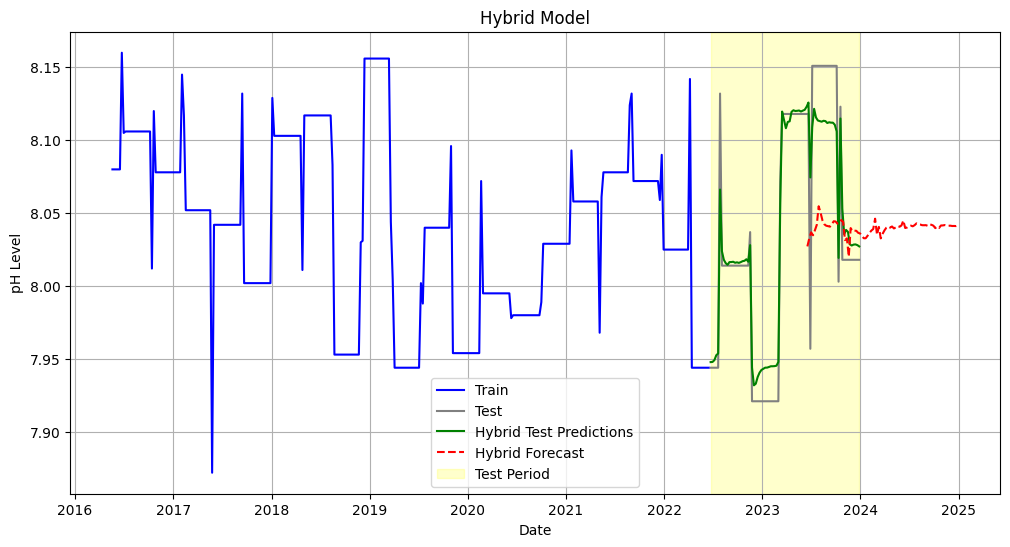

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone
from sklearn.linear_model import RidgeCV
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Parameters
RANDOM_STATE = 42
LAGS = 72
overlap = 25
forecast_start_date = pd.to_datetime("2023-06-15")
TARGET = "pH Level"
ROLL_WINDOWS = [7, 14, 30, 60]  # Rolling mean windows

df = working_copy.copy()

dates = df.index

# Selecting features
possible_features = [
    "Location", "Latitude", "Longitude",
    "SST (°C)", "Species Observed",
    "Bleaching Severity Encoded",
    "Marine Heatwave Encoded"
]
features = [f for f in possible_features if f in df.columns]

# Rolling mean features
for w in ROLL_WINDOWS:
    df[f"{TARGET}_rollmean_{w}"] = df[TARGET].rolling(window=w).mean()

# lag features
def create_lags(df, target_col, lags=3):
    df_lag = df.copy()
    for lag in range(1, lags + 1):
        df_lag[f"{target_col}_lag{lag}"] = df_lag[target_col].shift(lag)

    df_lag = df_lag.dropna().reset_index(drop=True)

    # use existing index after dropping NA
    df_lag["Date"] = df.index[lags:]

    return df_lag

df_lagged = create_lags(df, TARGET, lags=LAGS)

lag_features = [f"{TARGET}_lag{lag}" for lag in range(1, LAGS + 1)]
roll_features = [f"{TARGET}_rollmean_{w}" for w in ROLL_WINDOWS]
all_features = features + lag_features + roll_features

X = df_lagged[all_features].copy()
y = df_lagged[TARGET].copy()
dates = df_lagged["Date"]

# Train/test split
TEST_SIZE = 0.2
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_train, dates_test = dates.iloc[:split_idx], dates.iloc[split_idx:]

cat_features = [c for c in X.columns if X[c].dtype == 'object' or X[c].dtype.name == 'category']
num_features = [c for c in X.columns if c not in cat_features]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

# Random Forest
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', rf)
])

# TimeSeriesSplit CV
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

print("\n=== TimeSeriesSplit Fold Metrics ===")
fold_train_rmse, fold_train_mae, fold_train_r2 = [], [], []
fold_val_rmse, fold_val_mae, fold_val_r2 = [], [], []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    fold_model = clone(pipeline)
    fold_model.fit(X_tr, y_tr)

    y_tr_pred = fold_model.predict(X_tr)
    fold_train_rmse.append(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    fold_train_mae.append(mean_absolute_error(y_tr, y_tr_pred))
    fold_train_r2.append(r2_score(y_tr, y_tr_pred))

    y_val_pred = fold_model.predict(X_val)
    fold_val_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    fold_val_mae.append(mean_absolute_error(y_val, y_val_pred))
    fold_val_r2.append(r2_score(y_val, y_val_pred))

    print(f"Fold {fold+1}:")
    print(f"  Train -> RMSE={fold_train_rmse[-1]:.4f}, MAE={fold_train_mae[-1]:.4f}, R2={fold_train_r2[-1]:.4f}")
    print(f"  Val   -> RMSE={fold_val_rmse[-1]:.4f}, MAE={fold_val_mae[-1]:.4f}, R2={fold_val_r2[-1]:.4f}")

print("\nAverage Training metrics (fold-wise):")
print(f"Mean RMSE: {np.mean(fold_train_rmse):.4f}")
print(f"Mean MAE : {np.mean(fold_train_mae):.4f}")
print(f"Mean R2  : {np.mean(fold_train_r2):.4f}")

print("\nAverage Validation metrics (fold-wise):")
print(f"Mean RMSE: {np.mean(fold_val_rmse):.4f}")
print(f"Mean MAE : {np.mean(fold_val_mae):.4f}")
print(f"Mean R2  : {np.mean(fold_val_r2):.4f}")

# Grid search
param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2'
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)

# Train ridge on RF residuals
print("\n=== Training Ridge Regression on RF Residuals ===")
rf_train_pred = best_model.predict(X_train)
residuals_train = y_train - rf_train_pred
X_train_pre = best_model.named_steps['pre'].transform(X_train)

ridge_model = RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5)
ridge_model.fit(X_train_pre, residuals_train)
print("Ridge selected alpha:", ridge_model.alpha_)

# Test Evaluation
y_test_pred_rf = best_model.predict(X_test)
X_test_pre = best_model.named_steps['pre'].transform(X_test)
ridge_test = ridge_model.predict(X_test_pre)
y_test_hybrid = y_test_pred_rf + ridge_test

final_rmse = np.sqrt(mean_squared_error(y_test, y_test_hybrid))
final_mae = mean_absolute_error(y_test, y_test_hybrid)
final_r2 = r2_score(y_test, y_test_hybrid)

print("\n=== Hybrid Model Test Metrics ===")
print(f"R2: {final_r2:.4f}, MAE: {final_mae:.4f}, RMSE: {final_rmse:.4f}")

# Forecasting
freq = 'W'
future_index = pd.date_range(start=forecast_start_date, end=pd.to_datetime("2024-12-31"), freq=freq)
FORECAST_WEEKS = len(future_index)

if overlap > 0:
    X_forecast_input = pd.concat([
        X_test.iloc[:overlap],
        X_test.iloc[-(FORECAST_WEEKS - overlap):]
    ])
else:
    X_forecast_input = X_test.iloc[-FORECAST_WEEKS:]

last_known = X_forecast_input.tail(LAGS).copy().reset_index(drop=True)
future_preds = []

for i in range(FORECAST_WEEKS):
    X_next = last_known.tail(LAGS).iloc[-1]
    X_next_df = pd.DataFrame([X_next], columns=all_features)
    X_next_pre = best_model.named_steps['pre'].transform(X_next_df)

    y_next_rf = best_model.predict(X_next_df)[0]
    y_next_resid = ridge_model.predict(X_next_pre)[0]
    y_next = y_next_rf + y_next_resid
    future_preds.append(y_next)

    new_row = X_next.copy()
    for lag in range(LAGS, 1, -1):
        new_row[f"{TARGET}_lag{lag}"] = new_row[f"{TARGET}_lag{lag-1}"]
    new_row[f"{TARGET}_lag1"] = y_next

    last_known = pd.concat([last_known, new_row.to_frame().T], ignore_index=True)

y_forecast_series = pd.Series(future_preds, index=future_index)

manual_overlap = min(overlap, len(y_test), len(y_forecast_series))

if manual_overlap > 0:
    print(f"\n=== Forecast Evaluation ({manual_overlap} overlapping points) ===")
    
    y_overlap_actual = y_test.iloc[:manual_overlap]
    
    y_overlap_forecast = y_forecast_series.iloc[:manual_overlap]

    forecast_rmse = np.sqrt(mean_squared_error(y_overlap_actual, y_overlap_forecast))
    forecast_mae = mean_absolute_error(y_overlap_actual, y_overlap_forecast)

    naive_errors = np.abs(y_overlap_actual.values[1:] - y_overlap_actual.values[:-1])
    naive_mae = np.mean(naive_errors)

    forecast_mase = forecast_mae / naive_mae if naive_mae != 0 else np.nan

    print(f"Forecast RMSE: {forecast_rmse:.4f}")
    print(f"Forecast MAE : {forecast_mae:.4f}")
    print(f"Forecast MASE: {forecast_mase:.4f}")

else:
    print("No overlap available for calculating forecast accuracy.")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_test, y_test, label='Test', color='gray')
plt.plot(dates_test, y_test_hybrid, label='Hybrid Test Predictions', color='green')
plt.plot(future_index, y_forecast_series, label='Hybrid Forecast', color='red', linestyle='--')

plt.axvspan(dates_test.iloc[0], dates_test.iloc[-1], color='yellow', alpha=0.2, label='Test Period')
plt.xlabel('Date')
plt.ylabel('pH Level')
plt.title('Hybrid Model')
plt.legend()
plt.grid(True)
plt.show()


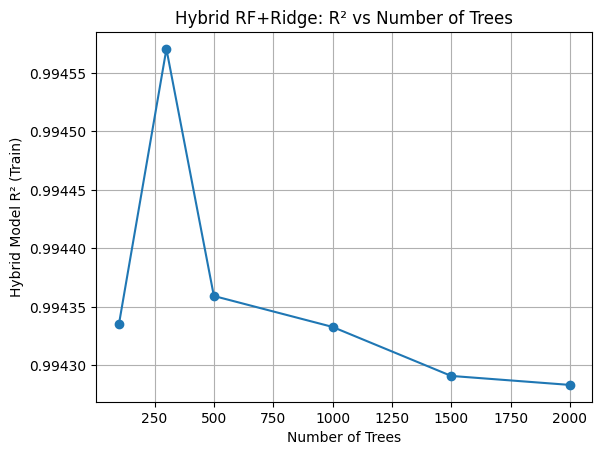

R² for different n_estimators: {100: 0.9943352950212551, 300: 0.9945704720888559, 500: 0.9943593020497152, 1000: 0.9943328549133387, 1500: 0.9942909710180889, 2000: 0.9942832812398015}


In [18]:

from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.base import clone
import numpy as np
import matplotlib.pyplot as plt

n_tree_list = [100, 300, 500, 1000, 1500, 2000]
r2_scores = []

# Preprocess features once
X_train_pre = best_model.named_steps['pre'].transform(X_train)

for n in n_tree_list:

    rf_temp = RandomForestRegressor(
        n_estimators=n,
        max_depth=10,
        min_samples_split=20,
        random_state=42,
        n_jobs=-1
    )
    rf_temp.fit(X_train_pre, y_train)

    residuals_train = y_train - rf_temp.predict(X_train_pre)
    ridge_temp = RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5)
    ridge_temp.fit(X_train_pre, residuals_train)
    y_train_hybrid = rf_temp.predict(X_train_pre) + ridge_temp.predict(X_train_pre)
    r2_scores.append(r2_score(y_train, y_train_hybrid))

# Plot 
plt.plot(n_tree_list, r2_scores, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("Hybrid Model R² (Train)")
plt.title("Hybrid RF+Ridge: R² vs Number of Trees")
plt.grid(True)
plt.show()

print("R² for different n_estimators:", dict(zip(n_tree_list, r2_scores)))



# -- Stability --

## Weak pH ranges


=== Error Metrics by pH Range ===
    pH_Range       MAE      RMSE  Count
0  7.87-7.95  0.017523  0.019121   20.0
1  7.95-8.05  0.012188  0.024840   28.0
2  8.05-8.15  0.008096  0.016560   18.0
3  8.15-8.20  0.038386  0.038528   14.0


C:\Users\kestr\AppData\Local\Temp\ipykernel_12368\702728796.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_bin = results_df.groupby('pH_Range').apply(


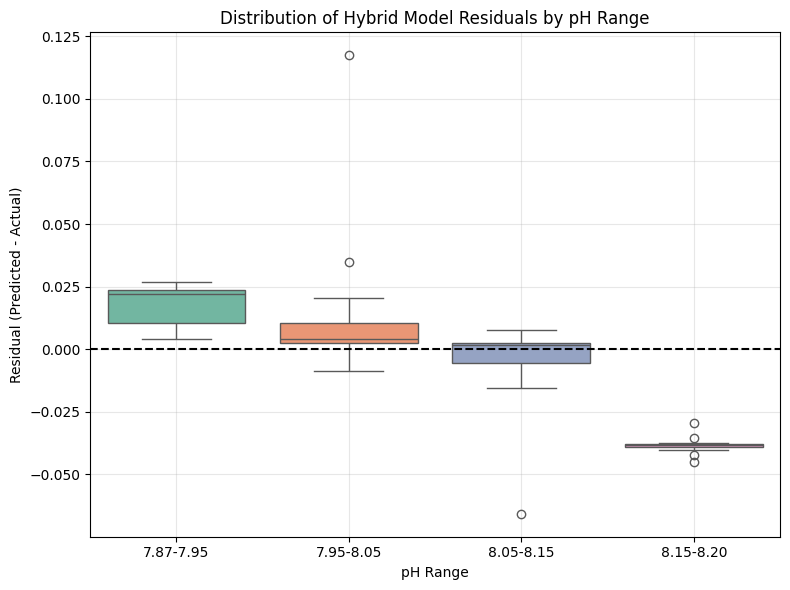

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define pH bins

bins = [7.87, 7.95, 8.05, 8.15, 8.20]
labels = ['7.87-7.95', '7.95-8.05', '8.05-8.15', '8.15-8.20']


min_len = min(len(y_test), len(y_test_hybrid))
y_test_aligned = y_test.iloc[-min_len:]  # last min_len entries
y_pred_aligned = y_test_hybrid[-min_len:]

# Assign bins

y_test_binned = pd.cut(y_test_aligned, bins=bins, labels=labels)

# results

results_df = pd.DataFrame({
'Actual_pH': y_test_aligned.values,
'Predicted_pH': y_pred_aligned,
'Residual': y_pred_aligned - y_test_aligned.values,
'pH_Range': y_test_binned.values
})

# metrics

metrics_per_bin = results_df.groupby('pH_Range').apply(
lambda df: pd.Series({
'MAE': mean_absolute_error(df['Actual_pH'], df['Predicted_pH']),
'RMSE': np.sqrt(mean_squared_error(df['Actual_pH'], df['Predicted_pH'])),
'Count': len(df)
})
).reset_index()

print("\n=== Error Metrics by pH Range ===")
print(metrics_per_bin)

# Plot

plt.figure(figsize=(8, 6))
sns.boxplot(x='pH_Range', y='Residual', data=results_df, palette='Set2')
plt.axhline(0, color='black', linestyle='--')
plt.title('Distribution of Hybrid Model Residuals by pH Range')
plt.xlabel('pH Range')
plt.ylabel('Residual (Predicted - Actual)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Hybrid_pH_Ranges_Residuals.png")
plt.show()


## Stability master plot

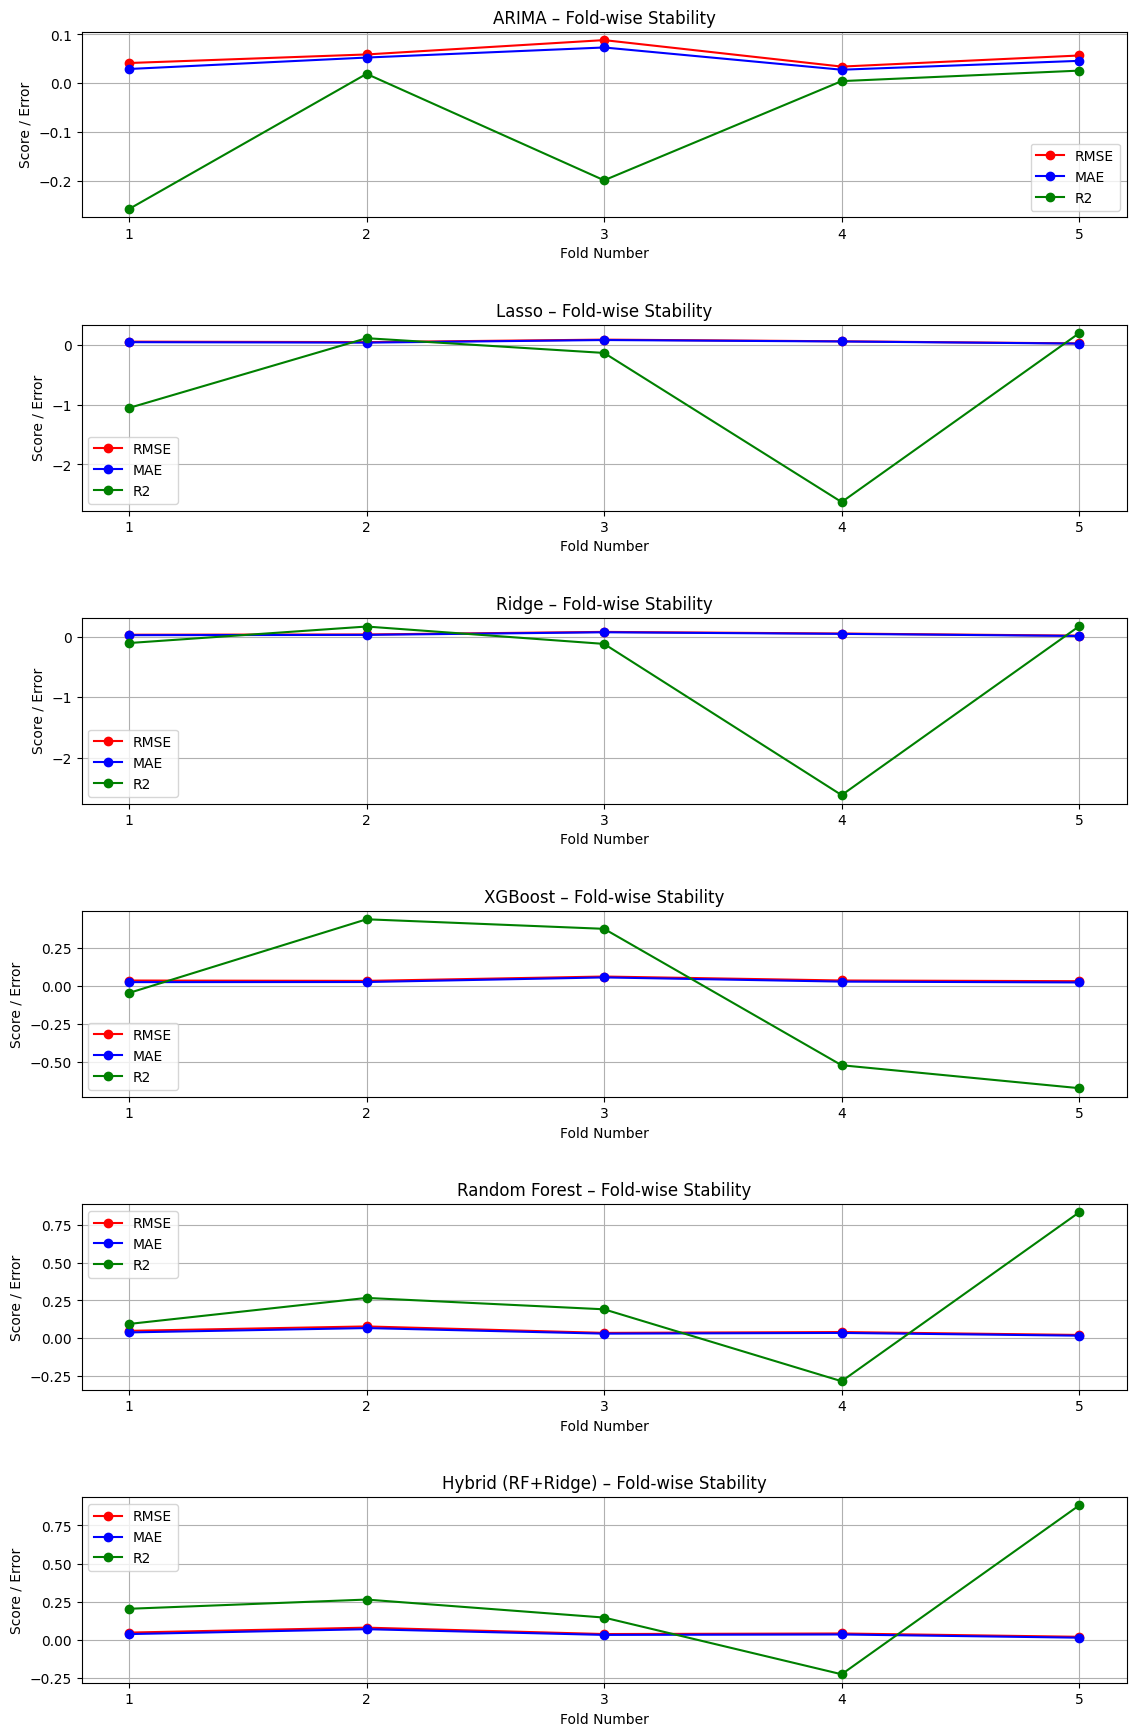

In [20]:
import matplotlib.pyplot as plt
import numpy as np

model_metrics = {
    "ARIMA": {"RMSE": fold_rmse_arima, "MAE": fold_mae_arima, "R2": fold_r2_arima},
    "Lasso": {"RMSE": fold_rmse_lasso, "MAE": fold_mae_lasso, "R2": fold_r2_lasso},
    "Ridge": {"RMSE": fold_val_rmse_ridge, "MAE": fold_val_mae_ridge, "R2": fold_val_r2_ridge},
    "XGBoost": {"RMSE": fold_val_rmse_xg, "MAE": fold_val_mae_xg, "R2": fold_val_r2_xg},
    "Random Forest": {"RMSE": fold_val_rmse_rf, "MAE": fold_val_mae_rf, "R2": fold_val_r2_rf}, 
    "Hybrid (RF+Ridge)": {"RMSE": fold_val_rmse, "MAE": fold_val_mae, "R2": fold_val_r2}
}

num_models = len(model_metrics)
plt.figure(figsize=(12, 3*num_models))

# Colors for metrics
metric_colors = {"RMSE": "red", "MAE": "blue", "R2": "green"}

for i, (model_name, metrics) in enumerate(model_metrics.items(), start=1):
    plt.subplot(num_models, 1, i)
    
    num_folds = len(metrics["RMSE"])
    folds = np.arange(1, num_folds + 1)
    
    # Plot 
    for metric_name, color in metric_colors.items():
        plt.plot(folds, metrics[metric_name], marker='o', label=metric_name, color=color)
    
    plt.title(f"{model_name} – Fold-wise Stability")
    plt.xlabel("Fold Number")
    plt.ylabel("Score / Error")
    plt.xticks(folds)
    plt.tight_layout(pad=3.0)
    plt.grid(True)
    plt.legend()

plt.show()


# -- Feature Importance Analysis -- 

## Performance Degradation Analysis

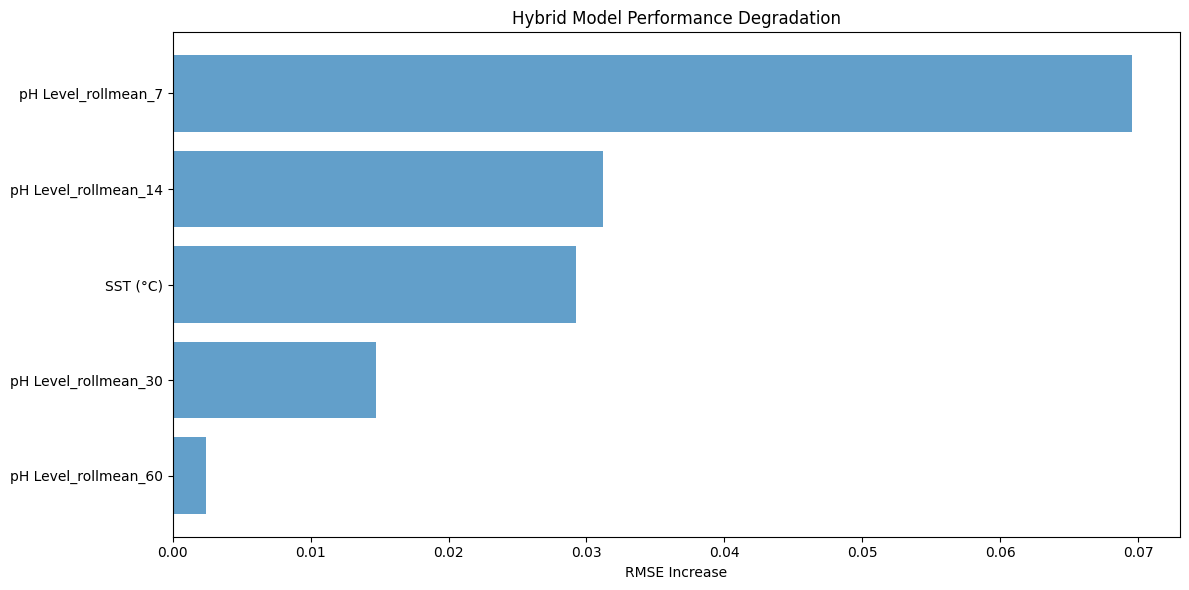

In [21]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

rf_pred = best_model.predict(X_test)
ridge_pred = ridge_model.predict(best_model.named_steps['pre'].transform(X_test))
y_pred_base = rf_pred + ridge_pred
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))

# Degradation analysis

degradation_results = []

for feature in X_test.columns:
    try:
        x_mod = deepcopy(X_test)

        if np.issubdtype(x_mod[feature].dtype, np.number):
            replacement = x_mod[feature].mean()
        else:  # categorical/string
            replacement = x_mod[feature].mode()[0]

        x_drop = x_mod.copy()
        x_drop[feature] = replacement

        rf_pred_drop = best_model.predict(x_drop)
        ridge_pred_drop = ridge_model.predict(best_model.named_steps['pre'].transform(x_drop))
        y_pred_drop = rf_pred_drop + ridge_pred_drop
        rmse_drop = np.sqrt(mean_squared_error(y_test, y_pred_drop))

        degradation_results.append({
        'Feature': feature,
        'RMSE Increase Drop': rmse_drop - baseline_rmse
        })

    except Exception as e:
        print(f"Error processing {feature}: {e}")

# Results 

degradation_df = pd.DataFrame(degradation_results)
degradation_df = degradation_df.sort_values(by='RMSE Increase Drop', ascending=False)

# Plot

top_features = degradation_df.head(5)
plt.figure(figsize=(12, 6))
plt.barh(top_features['Feature'], top_features['RMSE Increase Drop'], alpha=0.7)
plt.xlabel('RMSE Increase')
plt.title('Hybrid Model Performance Degradation')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('Hybrid_Degradation.png')
plt.show()


## Permuation Feature Importance


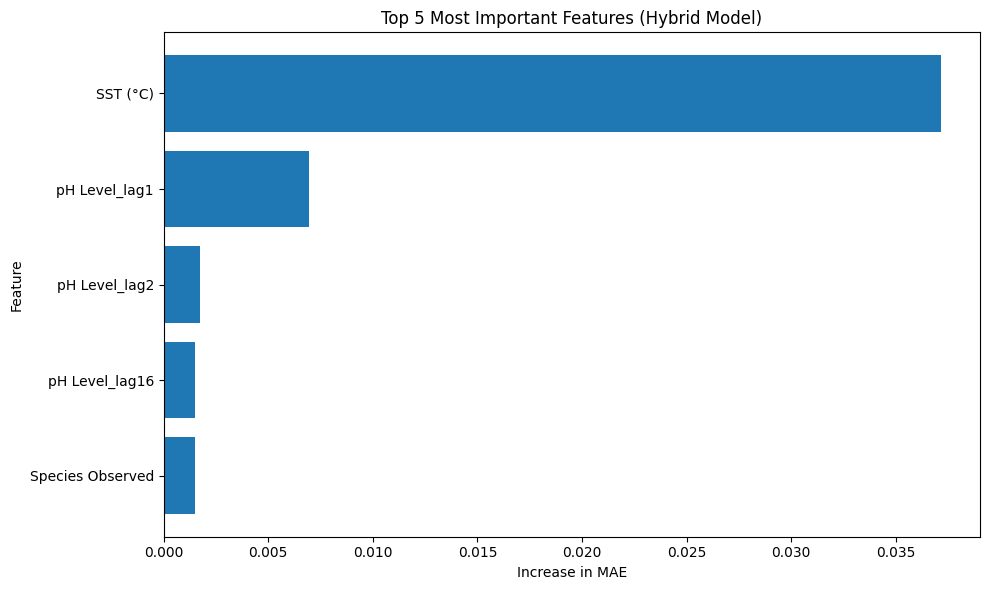

In [22]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin

numeric_features = [
    'Latitude', 'Longitude', 'SST (°C)', 'Species Observed',
    'Bleaching Severity Encoded', 'Marine Heatwave Encoded'
] + [f"pH Level_lag{i}" for i in range(1, 25)]

categorical_features = ['Location']


preprocessor = ColumnTransformer(
    transformers=[
        (
            'num',
            Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]),
            numeric_features,
        ),
        (
            'cat',
            Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
            ]),
            categorical_features,
        ),
    ]
)


# Random Forest pipeline

rf_pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=1000,
        max_depth=10,
        min_samples_split=20,
        n_jobs=-1,
        random_state=42
    ))
])

# Ridge 

alphas = np.logspace(-4, 4, 100)

ridge_pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', RidgeCV(alphas=alphas, cv=5))
])

# Hybrid Model

class HybridPermModel(BaseEstimator, RegressorMixin):

    def __init__(self, rf_pipeline=None, ridge_pipeline=None, weight_rf=0.5):
        self.rf_pipeline = rf_pipeline
        self.ridge_pipeline = ridge_pipeline
        self.weight_rf = weight_rf

    def fit(self, X, y):
        self.rf_pipeline.fit(X, y)
        self.ridge_pipeline.fit(X, y)
        return self

    def predict(self, X):
        rf_pred = self.rf_pipeline.predict(X)
        ridge_pred = self.ridge_pipeline.predict(X)
        return self.weight_rf * rf_pred + (1 - self.weight_rf) * ridge_pred

    def get_params(self, deep=True):
        return {
            "rf_pipeline": self.rf_pipeline,
            "ridge_pipeline": self.ridge_pipeline,
            "weight_rf": self.weight_rf
        }

    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

# Fit hybrid model

hybrid_model = HybridPermModel(
    rf_pipeline=rf_pipeline,
    ridge_pipeline=ridge_pipeline,
    weight_rf=0.5
)

hybrid_model.fit(X_train, y_train)

# Permutation Importance

perm_result = permutation_importance(
    hybrid_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Results 
importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance Mean": perm_result.importances_mean,
    "Importance Std": perm_result.importances_std
}).sort_values("Importance Mean", ascending=False)

# Plot
top5 = importance_df.sort_values("Importance Mean", ascending=False).head(5)
top5 = top5.sort_values("Importance Mean", ascending=True)  # reverse for barh readability

plt.figure(figsize=(10, 6))
plt.barh(top5["Feature"], top5["Importance Mean"])
plt.xlabel("Increase in MAE")
plt.ylabel("Feature")
plt.title("Top 5 Most Important Features (Hybrid Model)")
plt.tight_layout()
plt.savefig('Permutation_Feature_Importance_RMSE.png')
plt.show()
